# CMB-S4 Instrumentation Summer School

## Holography Lab Notebook #1: Bonus Optics!

In this notebook we will explore diffraction due to various aperture sizes and shapes.  The Fraunhofer description is taken from [Jeff McMahon's notebook](https://github.com/jeffmcm1977/ASTR30600/blob/main/Optics_v2.ipynb).

## Fraunhofer diffraction

[Fraunhofer diffraction](https://en.wikipedia.org/wiki/Fraunhofer_diffraction) describes light pripigateion in fhe far field region at a distance $z$ from an optic of diameter $D$ where $z$ is large compared  to the confocal distance.  The [Fraunhofer equation](https://en.wikipedia.org/wiki/Fraunhofer_diffraction_equation) give the eletric field in the far field $U(x,y,z)$ in terms of an integral over the two-dimensional field on the diffracting aperture $A(x',y')$. 


$$U(x,y,z) = \int_{Aperature} A(x',y')e^{i\frac{2 \pi}{\lambda}(\frac x z x' + \frac y z y')} dx' dy'$$  

Here I am addopting the notation from Wikipedia :(.  Note that both $U$ and $A$ are complex functions and in their full glory are vector fields.   In what follows we will consider only the dominat polarizaiton and will apporximate $U$ and $A$ as scalars. This equaiton can be drived by summing the phase of all paths from the source to the field point of interest and making various geometrical simplications as discussed [here](https://en.wikipedia.org/wiki/Fraunhofer_diffraction).

In the small angle limit (e.g., where $x << z$ and $y << z$, we can introduce angular coordiantes $\theta_x$ and $\theta_y$ and rewrite this equation as:

$$U(\theta_x,\theta_y) = \int_{Aperature} A(x',y')e^{i\frac{2 \pi}{\lambda}( \theta_x x' + \theta_y y')}dx' dy'$$

We will work exclusively with this form of the equation since it eliminates the cumborsome and $z$ depandnace in favor of an agular treatment that contains all the inforamtion.  You will notice that this equation is exactly a two dimensional fourier transfomrm.  This to compute the far field diffraciton pattern, all we need to do is to take the fields on the aperture and carry out the FFT to arrive at the diffraction pattern.   We will work a number of numerical examples.

One extremely useful note:  If we have a two dimensional array that represents the aperature fields $A$ whcih has $N$ points on each side at a spacing $\Delta x = \Delta y$, then the grid spacing of the far field is given by $\Delta \theta_x = \Delta \theta_y = \frac \lambda { N \Delta x}. $ Equivelently, the length of a side of our far field grid is $\frac \lambda {\Delta_x}.

A second useful note is that when it comes to interpreting these results we will often plot the square of the far field.  This is because the received power is proporational to $E^2$ so we can interpret this as the probility that a photon emitted from a partical direction will be detected by our system.

## Telescope #1: Circular Aperture
### Simons Observatory Large Aperture Telescope (similar: Atacama Cosmology Telescope)

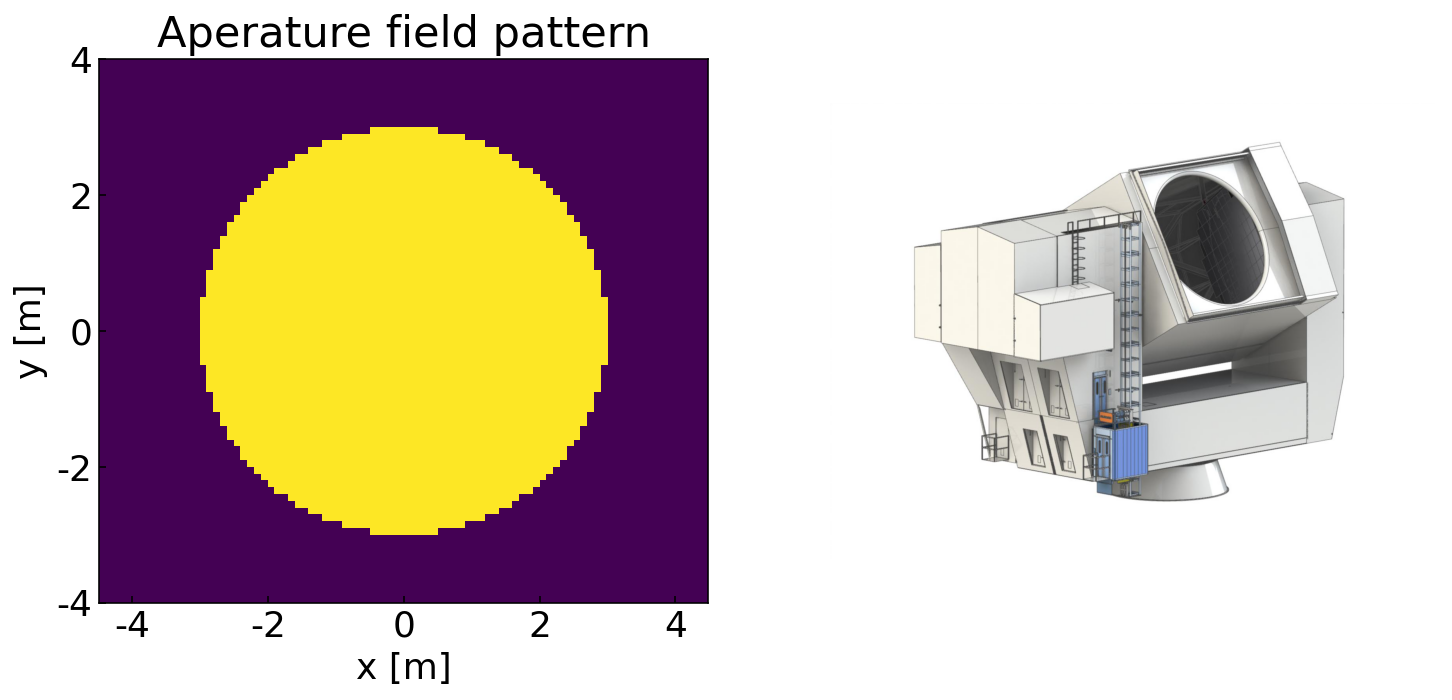

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img

matplotlib.rcParams["font.size"] = 18
plt.rcParams["axes.unicode_minus"] = False
matplotlib.rcParams.update({'xtick.direction':'in','ytick.direction':'in'})

%config InlineBackend.figure_format = 'retina'

## set up the aperature fields
N = 1000  ## number of samples in the aparture plane
L = 100.  # lenght of the aperture plane in meters-- this must be bigger than field region.
         ## NOTE-- L = N*Delta_x as defined in the text above 
Diam = 6. ## the diameter of our optic
delta_x = L / N # 


## define a funciton to make coordinates for our aperature plane grid
def make_coordinate_grids(N,L):
    ## make coordinate arrays on the aperature palne
    y,x = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                      np.linspace(-L/2,L/2,N))
    r = np.sqrt(x**2 + y**2)                    ## radial coordainte
    phi = np.arctan2(y,x)                      ## polar coordinate
    return(x,y,r,phi) 

plot_lim = 4.

###  make the coordinate grid
x,y,r,phi = make_coordinate_grids(N,L) ## 
    
## make the aperature fields 
A = np.ones([N,N]) 
A[np.where(r>Diam/2)] = 0 

plt.figure(figsize = (12,5))
## plot the aperature fields
plt.subplot(121)
plt.pcolormesh(x,y,A)
plt.axis("equal")
plt.title("Aperature field pattern")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)
plt.subplot(122)
plt.axis("off")

# reading png image
im = img.imread('point_source_figs/'+'LAT_ISO1.jpeg')
plt.imshow(im)
plt.show()

#### 1.A) How does the far-field beam change with frequency?
The resulting far-field beam has the diffraction pattern of an [Airy Disc](https://en.wikipedia.org/wiki/Airy_disk). On the right is the measured beam of Uranus from [ACT Data Releast 4](https://arxiv.org/pdf/2112.12226.pdf).  What in the diffraction pattern differs from your predicted beam? 

#### 1.B) Go back to the previous notebook cell and change the diameter ```Diam``` of the of the telescope.  How does this change the beam?  To observe features at 1 arcminute resolution, what diameter size do you recommend?

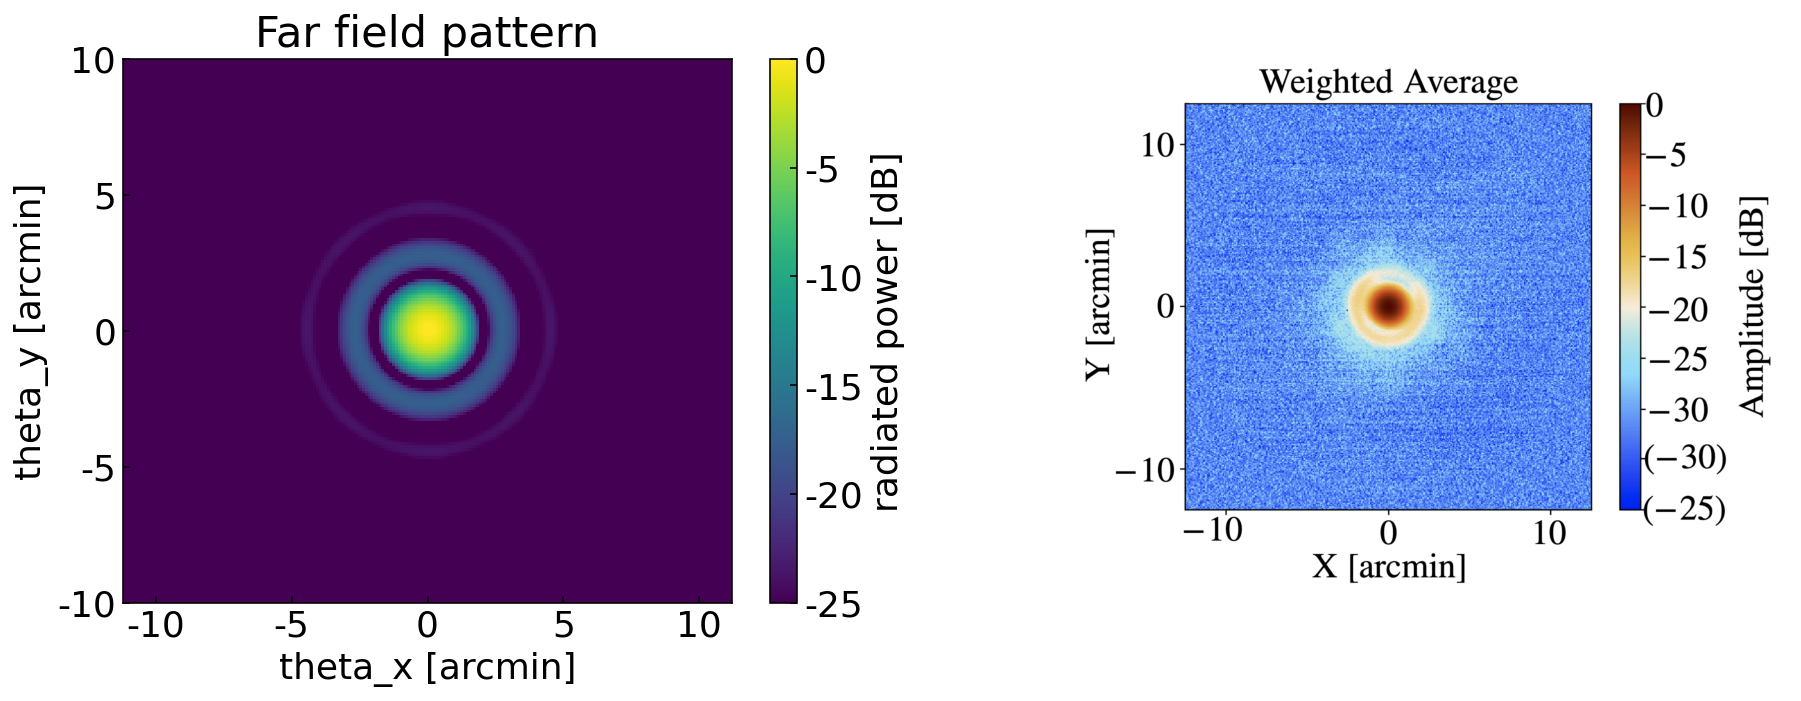

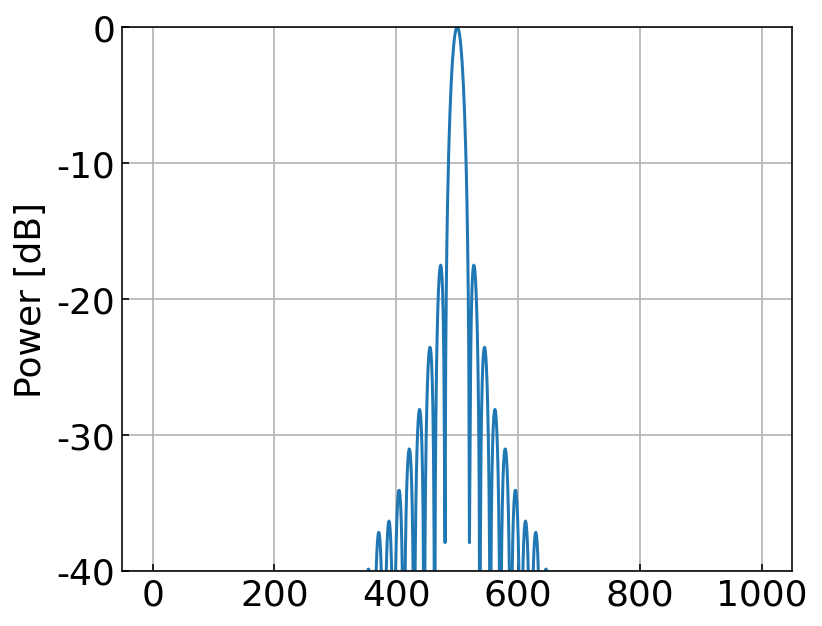

In [2]:
## choose a wavelegth
wavelength = 0.001 ## in meters


## compute Fraunhofer diffraciton and the coordinates of this diffraciotn paattern
def Fraunhofer(A,wavelength,delta_x):
    ## computers rock-- this is the entire calcuation.  Try doing this by hand for a comparsion
    U = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A)))
    ##. THIS WAS THE HARD PART!!!!  the rest is unit conversion and making a nice plot
        ####################################################
   ## now to make coordinates for these fields
    angular_width = wavelength / delta_x  ## this is in radians
    angular_width *= 180./np.pi       ## this converts to degrees
    angular_width *= 60      ## this converts to arcmin
    #angular_width *= 60      ## this converts to arcsec
    return(angular_width,U)

####################################################
## convert from electric field to radiated power or PSF
def Covnert_field_to_PSF(U):
    PSF = np.abs(U)**2
    PSF_temp= PSF / np.max(PSF)  ## peak normalized-- not the right thing for convolution... but is nice for seeing it
    ## make a logrythmic version of the radiated power so we can better see faint features
    PSF_temp +=1e-25 ## avoid infinities by regularizing zeroes
    PSF_dB = 10*np.log10(PSF_temp) ## convert to dB
    return(PSF, PSF_dB)


angular_width,U = Fraunhofer(A,wavelength,delta_x) ## compute the diffraction pattern
PSF,PSF_dB = Covnert_field_to_PSF(U) 


###########################################
## plot the aperature fields
plot_lim = 10

plt.figure(figsize = (15,5))
plt.subplot(121)
plt.pcolormesh(x,y,PSF_dB,
           vmin = -25,
           vmax = 0)
plt.axis("equal")
plt.colorbar(label = ("radiated power [dB]"))
# cbar.set_label, rotation=270)
plt.title("Far field pattern")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("theta_y [arcmin]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)

plt.subplot(122)
plt.axis("off")
# reading png image
im = img.imread('point_source_figs/'+'act_dr4.png')
plt.imshow(im)
plt.show()

plt.figure(figsize = (6,5))
plt.ylabel("Power [dB]")
plt.plot(PSF_dB[int(len(PSF_dB)/2),:])
plt.grid()
plt.ylim(-40,0)
plt.show()

## Telescope #2: Circular Aperture with a Cross
### National Radio Astronomy Observatory's 20-Meter Telescope (and many others!)

The [NRAO's Very Large Array radio telescope](https://www.gb.nrao.edu/20m/fantastic/) uses 4 arms in front of its antenna to hold a central mirror which then reflects the signal into its receiver.  These 4 arms create a cross pattern in the aperture field pattern, which create a unique diffraction effect. 

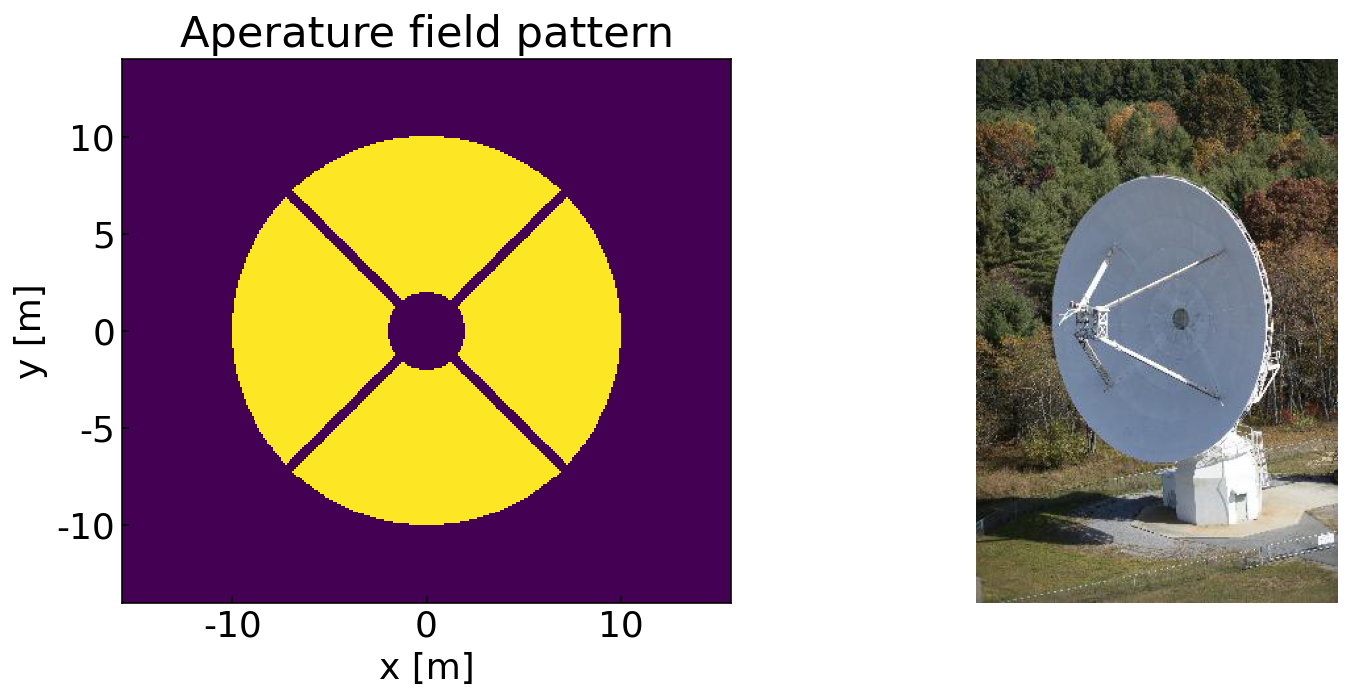

In [4]:
## set up the aperature fields
N = 1000  ## number of samples in the aparture plane
L = 100.  ## lenght of the aperture plane in meters-- this must be bigger than field region.
         ## NOTE-- L = N*Delta_x as defined in the text above 
Diam = 20. ## the diameter of our optic
delta_x = L / N

plot_lim = 14.

###  make the coordinate grid
x,y,r,phi = make_coordinate_grids(N,L) 
    
## make the aperature fields 
A = np.ones([N,N])
A[np.where(r>Diam/2)] = 0 

A[np.where(abs(y-x)<Diam*.02)] = 0 
A[np.where(abs(y+x)<Diam*.02)] = 0
A[np.where((x**2 + y**2)<(Diam/10)**2)] = 0

plt.figure(figsize = (12,5))
## plot the aperature fields
plt.subplot(121)
plt.pcolormesh(x,y,A)
plt.axis("equal")
plt.title("Aperature field pattern")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)
plt.subplot(122)
plt.axis("off")

# reading png image
im = img.imread('point_source_figs/'+'20Meter.small.jpg') 
plt.imshow(im)
plt.show()

The GBO 20-meter telescope is a radio telescope which operates from 1.3-10 GHz.  Change the frequency of the telescope and note how the beam changes (specifically how the diffraction pattern changes) at the low and high frequencies.

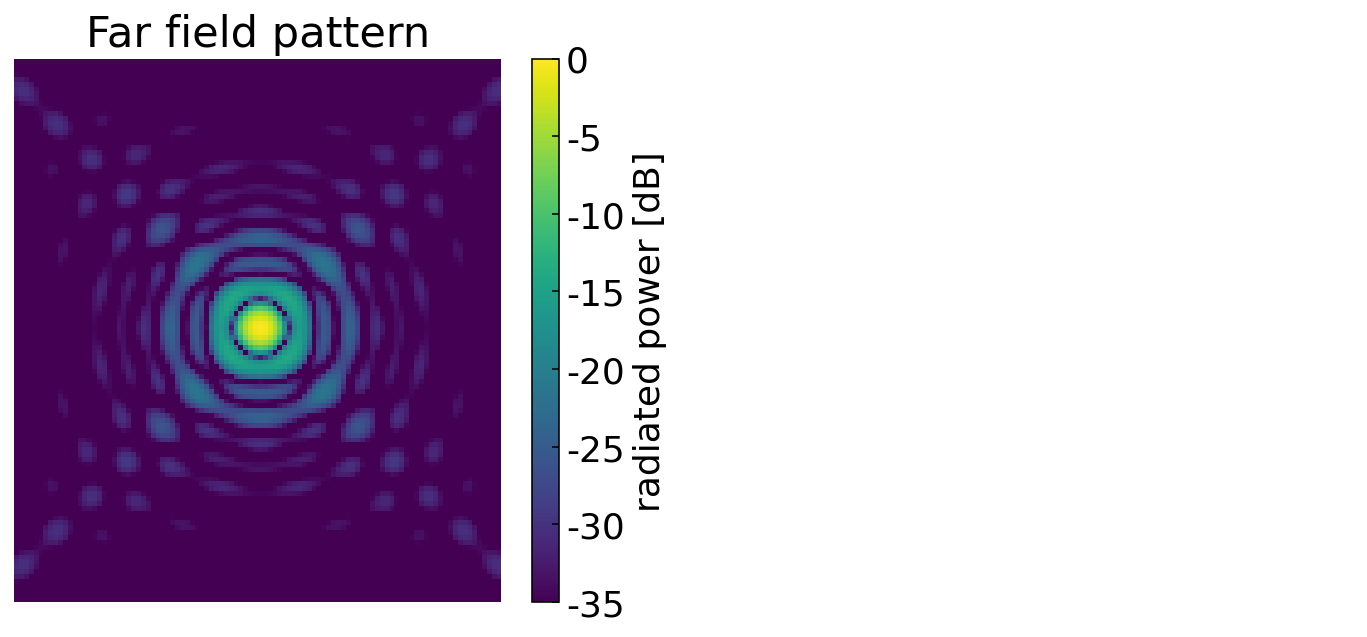

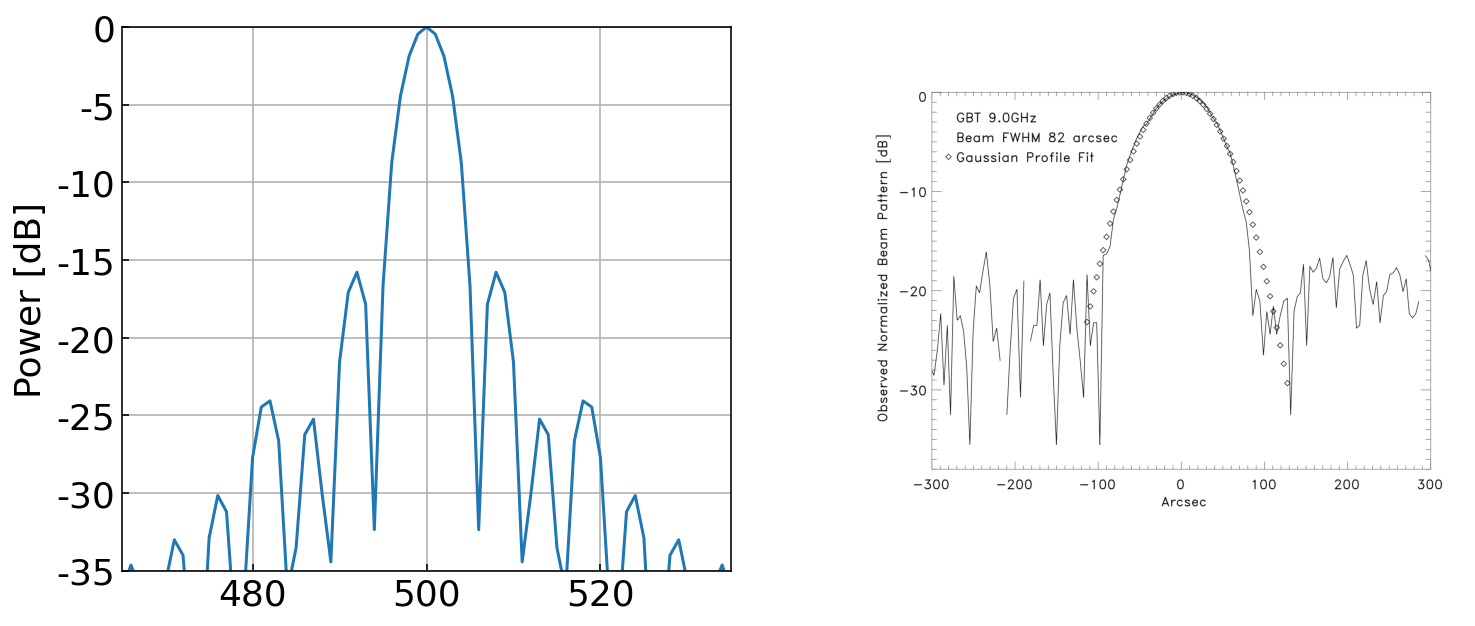

In [5]:
## choose a wavelegth
wavelength = 0.0333102731  ## 9GHz in meters

angular_width,U = Fraunhofer(A,wavelength,delta_x) ## compute the diffraction pattern
PSF,PSF_dB = Covnert_field_to_PSF(U) 


###########################################
## plot the aperature fields
plot_lim = 5.

plt.figure(figsize = (12,5))
plt.subplot(121)
plt.pcolormesh(x,y,PSF_dB,
           vmin = -35,
           vmax = 0)
plt.axis("equal")
plt.colorbar(label = ("radiated power [dB]"))
# cbar.set_label, rotation=270)
plt.title("Far field pattern")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("theta_y [arcmin]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)
plt.axis("off")
plt.subplot(122)
plt.axis("off")

plt.show()

plt.figure(figsize = (12,5))
plt.subplot(121)
plt.ylabel("Power [dB]")
plt.plot(PSF_dB[int(len(PSF_dB)/2),:])
plt.grid()
plt.ylim(-35,0)
plt.xlim(-35+500,35+500)

plt.subplot(122)
plt.axis("off")

im = img.imread('point_source_figs/'+'20m_beam.png')
plt.imshow(im)

plt.show()

## Telescope #3: Hexagonal Aperture
### James Webb Space Telescope

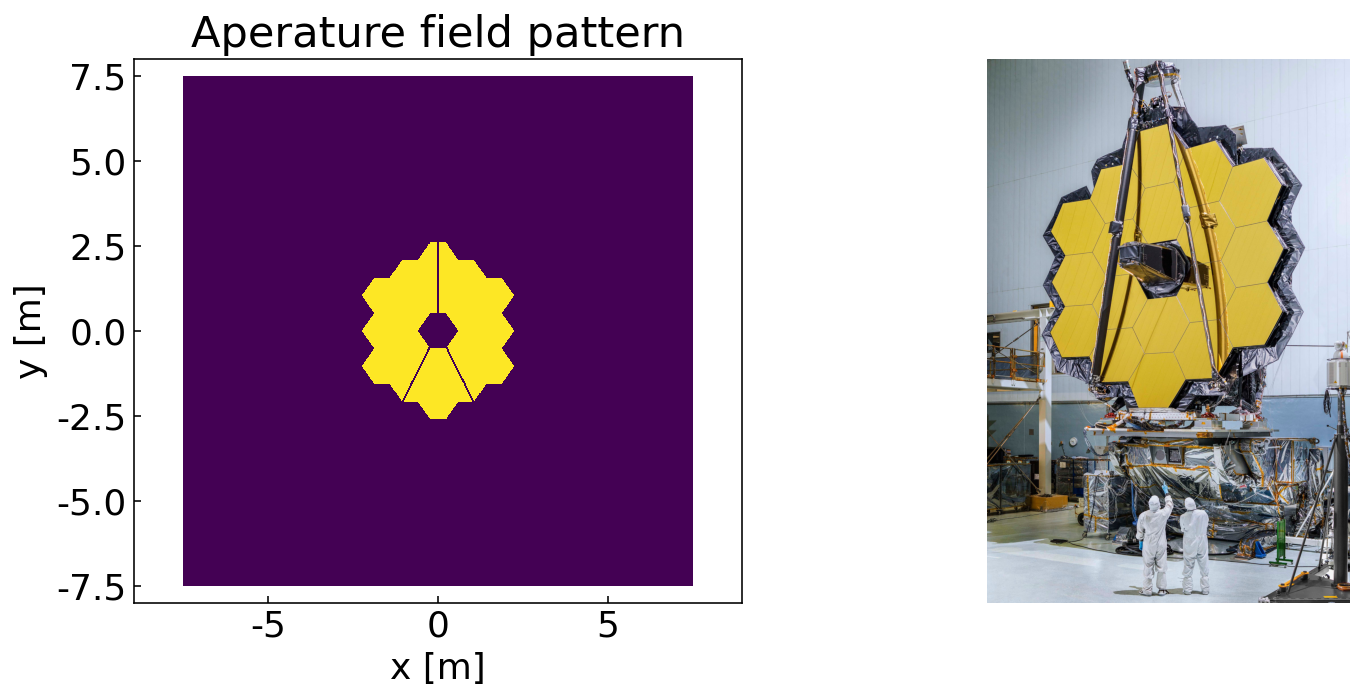

In [125]:
## set up the aperature fields
N = 1500  ## number of samples in the aparture plane
L = 15.  ## lenght of the aperture plane in meters-- this must be bigger than field region.
         ## NOTE-- L = N*Delta_x as defined in the text above 
Diam = .6 ## the diameter of our optic
delta_x = L / N

plot_lim = 8

###  make the coordinate grid
x,y,r,phi = make_coordinate_grids(N,L)
    
## make the aperature fields 

pan_space = 0.0

x_space = 1.94
A = np.ones([N,N])
A[np.where((abs(y)>=Diam*np.sqrt(3)/2))] = 0
A[np.where((abs(y)>= -(x-Diam)*np.sqrt(2)))] = 0
A[np.where((abs(y)>= (x+Diam)*np.sqrt(2)))] = 0

A_temp = np.ones([N,N])
A_temp[np.where((abs(y+2*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y+2*((1+pan_space)*Diam*np.sqrt(3)/2))>= -(x-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y+2*((1+pan_space)*Diam*np.sqrt(3)/2))>= (x+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y-2*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y-2*((1+pan_space)*Diam*np.sqrt(3)/2))>= -(x-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y-2*((1+pan_space)*Diam*np.sqrt(3)/2))>= (x+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y+4*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y+4*((1+pan_space)*Diam*np.sqrt(3)/2))>= -(x-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y+4*((1+pan_space)*Diam*np.sqrt(3)/2))>= (x+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y-4*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y-4*((1+pan_space)*Diam*np.sqrt(3)/2))>= -(x-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y-4*((1+pan_space)*Diam*np.sqrt(3)/2))>= (x+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y-((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y-((1+pan_space)*Diam*np.sqrt(3)/2))>= -((x-(Diam*1.38))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y-((1+pan_space)*Diam*np.sqrt(3)/2))>= ((x-(Diam*1.38))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y-((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y-((1+pan_space)*Diam*np.sqrt(3)/2))>= -((x+(Diam*1.38))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y-((1+pan_space)*Diam*np.sqrt(3)/2))>= ((x+(Diam*1.38))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y+((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y+((1+pan_space)*Diam*np.sqrt(3)/2))>= -((x-(Diam*1.38))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y+((1+pan_space)*Diam*np.sqrt(3)/2))>= ((x-(Diam*1.38))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y+((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y+((1+pan_space)*Diam*np.sqrt(3)/2))>= -((x+(Diam*1.38))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y+((1+pan_space)*Diam*np.sqrt(3)/2))>= ((x+(Diam*1.38))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y+3*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y+3*((1+pan_space)*Diam*np.sqrt(3)/2))>= -((x-(Diam*1.38))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y+3*((1+pan_space)*Diam*np.sqrt(3)/2))>= ((x-(Diam*1.38))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y+3*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y+3*((1+pan_space)*Diam*np.sqrt(3)/2))>= -((x+(Diam*1.38))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y+3*((1+pan_space)*Diam*np.sqrt(3)/2))>= ((x+(Diam*1.38))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y-3*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y-3*((1+pan_space)*Diam*np.sqrt(3)/2))>= -((x-(Diam*1.38))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y-3*((1+pan_space)*Diam*np.sqrt(3)/2))>= ((x-(Diam*1.38))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y-3*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y-3*((1+pan_space)*Diam*np.sqrt(3)/2))>= -((x+(Diam*1.38))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y-3*((1+pan_space)*Diam*np.sqrt(3)/2))>= ((x+(Diam*1.38))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y)>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y)>= -(x+(Diam*x_space*np.sqrt(2))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y)>= (x+(Diam*x_space*np.sqrt(2))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y)>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y)>= -(x-(Diam*x_space*np.sqrt(2))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y)>= (x-(Diam*x_space*np.sqrt(2))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y-2*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y-2*((1+pan_space)*Diam*np.sqrt(3)/2))>= -(x-(Diam*x_space*np.sqrt(2))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y-2*((1+pan_space)*Diam*np.sqrt(3)/2))>= (x-(Diam*x_space*np.sqrt(2))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y+2*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y+2*((1+pan_space)*Diam*np.sqrt(3)/2))>= -(x-(Diam*x_space*np.sqrt(2))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y+2*((1+pan_space)*Diam*np.sqrt(3)/2))>= (x-(Diam*x_space*np.sqrt(2))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y-2*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y-2*((1+pan_space)*Diam*np.sqrt(3)/2))>= -(x+(Diam*x_space*np.sqrt(2))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y-2*((1+pan_space)*Diam*np.sqrt(3)/2))>= (x+(Diam*x_space*np.sqrt(2))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.ones([N,N])
A_temp[np.where((abs(y+2*((1+pan_space)*Diam*np.sqrt(3)/2))>=Diam*np.sqrt(3)/2))] = 0
A_temp[np.where((abs(y+2*((1+pan_space)*Diam*np.sqrt(3)/2))>= -(x+(Diam*x_space*np.sqrt(2))-Diam)*np.sqrt(2)))] = 0
A_temp[np.where((abs(y+2*((1+pan_space)*Diam*np.sqrt(3)/2))>= (x+(Diam*x_space*np.sqrt(2))+Diam)*np.sqrt(2)))] = 0
A+=A_temp

A_temp = np.zeros([N,N])
A_temp[np.where((abs(y)<=Diam*np.sqrt(3)/2) & (abs(y)<= -(x-Diam)*np.sqrt(2)) & (abs(y)<= (x+Diam)*np.sqrt(2)))] = -1
A+=A_temp

A[np.where((abs(y-2*x)<Diam*.1)&(y<0))] = 0 
A[np.where((abs(y+2*x)<Diam*.1)&(y<0))] = 0 
A[np.where((abs(x)<Diam*.1/2)&(y>0))] = 0 

A[np.where(A==1)] = np.max(A)

plt.figure(figsize = (12,5))
## plot the aperature fields
plt.subplot(121)
plt.pcolormesh(x,y,A)
plt.axis("equal")
plt.title("Aperature field pattern")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)
plt.subplot(122)
plt.axis("off")

# reading png image
im = img.imread('point_source_figs/'+'jwst.jpg')
plt.imshow(im)
plt.show()

#### 3.A) Why do we only see diffraction on some of the point sources and not all of them?
#### 3.B) Why 6 diffraction spikes? Not a mathematical question, just brainstorm what you think.

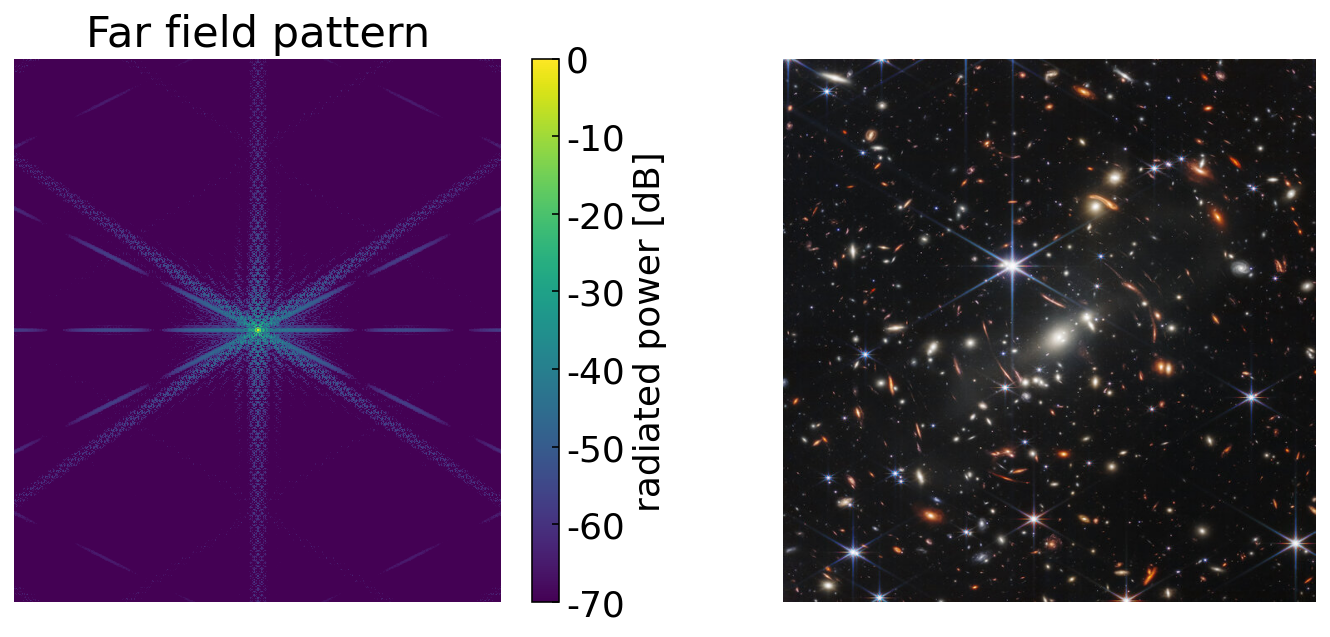

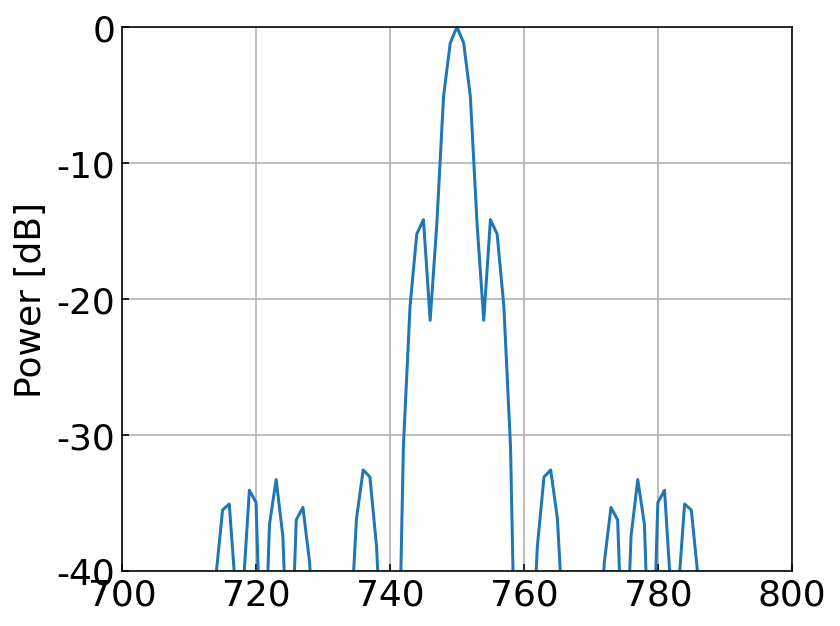

In [131]:
## choose a wavelegth
wavelength = 1E-6 ## in meters
angular_width,U = Fraunhofer(A,wavelength,delta_x)
PSF,PSF_dB = Covnert_field_to_PSF(U)

###########################################
## plot the aperature fields
plot_lim = 6

plt.figure(figsize = (12,5))
## plot the aperature fields
plt.subplot(121)

plt.pcolormesh(x,y,PSF_dB,
           vmin = -70,
           vmax = 0)
plt.axis("equal")
plt.colorbar(label = ("radiated power [dB]"))
# cbar.set_label, rotation=270)
plt.title("Far field pattern")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("theta_y [arcmin]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)
plt.axis("off")

plt.subplot(122)
plt.axis("off")

# reading png image
im = img.imread('point_source_figs/'+'jwst_pt.jpg')
plt.imshow(im)
plt.show()

plt.show()

plt.figure(figsize = (6,5))
plt.ylabel("Power [dB]")
plt.plot(PSF_dB[int(len(PSF_dB)/2),:])
plt.grid()
plt.xlim(700,800)
plt.ylim(-40,0)
plt.show()